In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sys
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

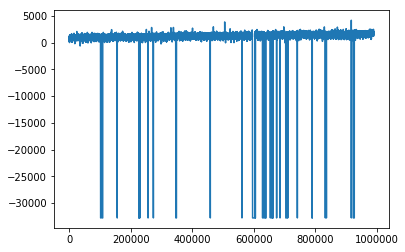

In [2]:
dfSL = pd.read_csv('Galveston.csv', header=None)
dfSL.rename(columns={0:'year',1:'month', 2:'day', 3:'hour', 4: 'sealevel'}, inplace=True)
fill_in = dfSL.loc[dfSL['sealevel']<-5000].median()[4]
dfSL['sealevel'].plot()
plt.show()

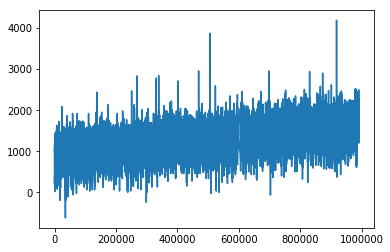

In [3]:
dfSL['sealevel'].replace(fill_in, np.nan, inplace=True)
dfSL.dropna(inplace=True)
dfSL['sealevel'].plot()
plt.show()

In [4]:
n_hours = 365*24
sl_year = {}
for index, row in dfSL.iterrows():
    year = row['year']
    sl = row['sealevel']
    if year in sl_year:
        sl_year[year].append(sl)
    else:
        sl_year[year] = []
        sl_year[year].append(sl)
        
gev = {}
for year, sealevel in sl_year.items():
    if len(sealevel)/n_hours >= 0.9:
        gev[year] = max(np.array(sealevel)-np.mean(sealevel))

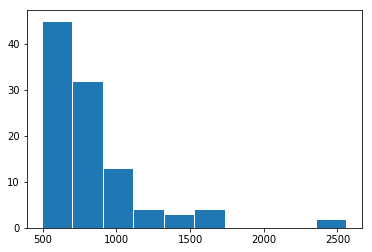

In [5]:
plt.hist(list(gev.values()), edgecolor="white")
plt.show()